In [ ]:
dir_ = '/Users/arthurcalvi/Data/species/validation/tiles'
import os
from datetime import datetime 
from utils import load_folder, calculate_slope_with_dates
import rasterio 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import davies_bouldin_score, cohen_kappa_score, confusion_matrix
from scipy.stats import ttest_ind


#read json config and get the new numerous of config
import json
if not os.path.exists('logs/config.json'):
    name_config = 'config_0'
    #create a new json file
    with open('logs/config.json', 'w') as f:
        data = {}
        json.dump(data, f)
else :
    with open('logs/config.json', 'r') as f:
        data = json.load(f)
        name_config = list(data.keys())
        #Sort 
        name_config.sort()
        name_config = name_config[-1]
        numero_config = int(name_config.split('_')[1]) + 1
        name_config = f'config_{numero_config}'

print(name_config)
os.makedirs('images', exist_ok=True)

# Placeholder for results
results = []

def calculate_metrics(true_labels, predicted_labels):
    """Calculate metrics for classification."""
    cm = confusion_matrix(true_labels, predicted_labels, labels=[1, 2])
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    oa = (tp + tn) / np.sum(cm)
    kappa = cohen_kappa_score(true_labels, predicted_labels)
    return oa, kappa, tp, fp, tn, fn

#remove warning
import warnings
warnings.filterwarnings("ignore")

for folder in tqdm(os.listdir(dir_)):

    path = os.path.join(dir_, folder)

    if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
        continue

    n_tuile = folder.split('_')[1]

    path_features = os.path.join(path, 'features')
    #check if r_APO.tif exists
    path = os.path.join(dir_, folder)

    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort() 
    rgb = load_folder(os.path.join(path, 'rgb'))
    # forest_mask = rasterio.open(os.path.join(path,'tree_map', 'tree_class_map.tif')).read(1).astype(bool)
    chm = rasterio.open(os.path.join(path,'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool) # 2.5m threshold 

    #weights 
    slope_map = calculate_slope_with_dates(rgb[:,0], dates, len(rgb[:,0])/2, len(rgb[:,0])) / 100 # 100 is the max slope value
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)
    updated_weights = weights 

    #features
    try: 
        r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
        amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]

        crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
        amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]

        dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
        elevation, aspect = dem[0], dem[1]

        # Define features
        f1 = amplitude_map_r
        f2 = np.cos(phase_map_r)
        f3 = np.sin(phase_map_r)
        f4 = offset_map_r
        f5 = amplitude_map_crswir
        f6= offset_map_crswir
        f7 = elevation 
        aspect_radians = np.radians(aspect)
        aspect_radians[ np.isnan(aspect_radians) ] = 0
        f8 = np.cos(aspect_radians)
        f9 = np.sin(aspect_radians)

        features = np.stack((f1.ravel(), f2.ravel(), f3.ravel(), f4.ravel(), f5.ravel(), f6.ravel(), f7.ravel(), f8.ravel(), f9.ravel()), axis=-1)
        filtered_features = features[forest_mask.ravel()]
        filtered_weights = weights[forest_mask.ravel()]

        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(filtered_features)

        # Determine the optimal number of clusters using the Elbow Method with MiniBatchKMeans
        # wcss = []  # Within-cluster sum of squares
        davies_bouldin_indices = []  # Davies-Bouldin index
        K = range(3, 11)  # You can adjust the range based on your data

        for k in K:
            minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
            clusters = minibatch_kmeans.fit_predict(features_scaled, sample_weight=filtered_weights)
            # wcss.append(minibatch_kmeans.inertia_)
            davies_bouldin_indices.append(davies_bouldin_score(features_scaled, clusters))

        # Determine the optimal number of clusters by finding the elbow point
        # optimal_k2 = K[np.argmax(np.diff(wcss, 2)) + 1]  # This uses the second derivative to find the elbow point
        optimal_k = K[np.argmin(davies_bouldin_indices)]
        # print(f"The optimal number of clusters is (wcss): {optimal_k2}")
        print(f"The optimal number of clusters is (davies bouldin): {optimal_k}")

        # Apply MiniBatchKMeans with the optimal number of clusters
        minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
        clusters = minibatch_kmeans.fit_predict(features_scaled, sample_weight=filtered_weights)

        # Reshape clusters to original shape
        cluster_map = np.full(f1.shape, -1)
        cluster_map.ravel()[forest_mask.ravel()] = clusters

        # Create the figure with two columns, adjusting the width ratios
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})

        # Plot the Davies-Bouldin Index for the Elbow Method
        ax1.plot(K, davies_bouldin_indices, 'bo-', label='Davies-Bouldin Index')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Davies-Bouldin Index')
        ax1.set_title('Davies-Bouldin Index For Optimal Number of Clusters')
        ax1.legend()
        ax1.grid(True, linestyle='--', linewidth=0.5)
        ax1.axvline(x=optimal_k, color='r', linestyle='--')
        ax1.text(optimal_k, min(davies_bouldin_indices), f' k={optimal_k}', color='r', verticalalignment='bottom')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Create a segmented colormap for clusters
        from matplotlib.colors import ListedColormap
        colors = plt.cm.viridis(np.linspace(0, 1, optimal_k+1))
        segmented_cmap = ListedColormap(colors)

        # Plot the KMeans Clustering of Features
        print(np.unique(cluster_map))
        im = ax2.imshow(cluster_map, cmap=segmented_cmap)
        cbar = plt.colorbar(im, ax=ax2, orientation='vertical', shrink=0.5, ticks=range(optimal_k))
        cbar.set_label('Cluster')
        cbar.set_ticks(np.arange(optimal_k) - 0.5)
        cbar.set_ticklabels([f'{i+1}' for i in range(optimal_k)])
        ax2.set_title('KMeans Clustering of Features')
        ax2.axis('off')

        # Adjust layout for a clean look
        plt.tight_layout()
        plt.show()
        fig.savefig(f'images/supplementarymaterials1_figure2_kmeans_tuile{n_tuile}.png', dpi=300)


        # Flatten and mask the values based on the forest mask
        values = amplitude_map_crswir.ravel()[forest_mask.ravel()]

        # Calculate the centroids of each cluster
        centroids = np.array([np.nanmean(values[clusters == i]) for i in range(optimal_k)]).reshape(-1, 1)

        # Perform hierarchical clustering on the centroids
        Z = linkage(centroids, method='ward')

        # Choose a threshold to form flat clusters from the dendrogram
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})
        dendro = dendrogram(Z, labels=[f'{i+1}' for i in range(optimal_k)], ax=ax1, color_threshold=Z[-2, 2])
        # max_d = np.max(dendro['dcoord']) * 0.7  # This value can be adjusted based on the dendrogram
        # Choose a threshold to form exactly two flat clusters from the dendrogram
        # Choose the number of clusters directly
        max_d = Z[-2, 2]
        # Form flat clusters based on the chosen number of clusters
        flat_clusters = fcluster(Z, max_d, criterion='distance')

        # Initialize group labels
        group1, group2 = 1, 2

        # Map flat clusters back to the original KMeans clusters
        cluster_mapping = {i: flat_clusters[i] for i in range(optimal_k)}

        # Create a new classification map based on the hierarchical clustering of centroids
        final_classification_map = np.full(cluster_map.shape, -1)
        for original_cluster, new_cluster in cluster_mapping.items():
            final_classification_map[cluster_map == original_cluster] = new_cluster

        # Collect CRSWIR amplitude values for each group
        group_amplitudes = {group: [] for group in [group1, group2]}
        for group in [group1, group2]:
            group_clusters = [i for i in range(optimal_k) if flat_clusters[i] == group]
            group_mask = np.isin(cluster_map, group_clusters)
            group_amplitudes[group] = amplitude_map_crswir[group_mask]

        # Compare the CRSWIR amplitudes between groups
        group1_amplitudes = np.array(group_amplitudes[group1])
        group2_amplitudes = np.array(group_amplitudes[group2])

        # Perform a t-test to compare the means of the two groups
        t_stat, p_value = ttest_ind(group1_amplitudes, group2_amplitudes, equal_var=False)

        # Determine which group is deciduous based on the t-test results
        mean_group1 = np.mean(group1_amplitudes)
        mean_group2 = np.mean(group2_amplitudes)

        print(f"Group {group1} - Mean amplitude CRSWIR: {mean_group1}")
        print(f"Group {group2} - Mean amplitude CRSWIR: {mean_group2}")
        print(f"T-test p-value: {p_value}")

        # Set significance level
        alpha = 0.05

        # Decision based on p-value
        if p_value < alpha and (mean_group1 >= 1.75 * mean_group2 or mean_group2 >= 1.75 * mean_group1):
            print(f"The hypothesis that one group has twice the amplitude of the other is not rejected.")
            if mean_group1 > mean_group2:
                deciduous_group = [group1]
                evergreen_group = [group2]
            else:
                deciduous_group = [group2]
                evergreen_group = [group1]
            
        else:
            # If the hypothesis is not rejected, use the threshold for classification
            deciduous_group = []
            evergreen_group = []
            if mean_group1 > 2000:
                deciduous_group.append(group1)
            else:
                evergreen_group.append(group1)
            if mean_group2 > 2000:
                deciduous_group.append(group2)
            else:
                evergreen_group.append(group2)
            print(f"The hypothesis that the two groups have significantly different amplitudes is rejected.")

        print(f"Deciduous groups: {deciduous_group}")
        print(f"Evergreen groups: {evergreen_group}")

        # Create a final classification map based on these groupings
        final_dec_ever_classification_map = np.full(cluster_map.shape, 0)
        for group in deciduous_group:
            group_clusters = [i for i in range(optimal_k) if flat_clusters[i] == group]
            final_dec_ever_classification_map[np.isin(cluster_map, group_clusters)] = 1  # Deciduous
        for group in evergreen_group:
            group_clusters = [i for i in range(optimal_k) if flat_clusters[i] == group]
            final_dec_ever_classification_map[np.isin(cluster_map, group_clusters)] = 2  # Evergreen

        # Create a custom colormap for the classification
        cmap = ListedColormap(['lightgray', 'brown', 'green'])

        # Plot the final classification map for deciduous and evergreen trees
        # Create the figure with two columns, adjusting the width ratios

        # Plot the dendrogram
        ax1.set_title('Hierarchical Clustering Dendrogram of KMeans Centroids')
        ax1.set_xlabel('Cluster')
        ax1.set_ylabel('Distance')
        ax1.grid(True, linestyle='--', linewidth=0.5)


        # Plot the final classification map for deciduous and evergreen trees
        im = ax2.imshow(final_dec_ever_classification_map, cmap=cmap)
        cbar = plt.colorbar(im, ax=ax2, ticks=[-1, 0, 1], orientation='vertical', pad=0.1, shrink=0.5)
        cbar.set_label('Tree Type')
        cbar.set_ticklabels(['No forest', 'Deciduous', 'Evergreen'])
        ax2.set_title('Classification Map')
        ax2.axis('off')

        # Adjust layout for a clean look
        plt.tight_layout()
        plt.show()

        # Save the figure
        fig.savefig(f'supplementarymaterials1_figure3_dendrogram-classification_tuile{n_tuile}.png', dpi=300)

        # save final classification as tif. in result folder
        os.makedirs(os.path.join(path, 'results_classification'), exist_ok=True)
        ref = rasterio.open(os.path.join(path, 'rgb', os.listdir(os.path.join(path, 'rgb'))[0]))
        profile = ref.profile
        profile.update(count=1, dtype=rasterio.uint8)
        with rasterio.open(os.path.join(path, 'results_classification', f'{name_config}.tif'), 'w', **profile) as dst:
            dst.write(final_dec_ever_classification_map.astype(rasterio.uint8), 1)
    
        #references 
        path_reference = os.path.join(path, 'reference_species')
        tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
        reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
        species, genus, phen, year, source = reference[0], reference[1], reference[2], reference[3], reference[4] 
        # Filter out null data
        valid_mask = species != 0

        # Calculate metrics
        true_labels = phen[forest_mask & valid_mask]
        predicted_labels = final_dec_ever_classification_map[forest_mask & valid_mask]

        oa, kappa, tp, fp, tn, fn = calculate_metrics(true_labels.ravel(), predicted_labels.ravel())

        # Store results
        r = {
            'tile': folder,
            'OA': oa,
            'Kappa': kappa,
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        }
        print(r)
        results.append(r)
    
    except Exception as e:
        print(e)
        continue

#compute OA_ALL, KAPPA_ALL, TP_ALL, FP_ALL, TN_ALL, FN_ALL FROM RESULTS

KAPPA_ALL = sum([r['Kappa'] for r in results if not np.isnan(r['Kappa'])]) / len(results)
TP_ALL = sum([r['TP'] for r in results])
FP_ALL = sum([r['FP'] for r in results])
TN_ALL = sum([r['TN'] for r in results])
FN_ALL = sum([r['FN'] for r in results])
OA_ALL = (TP_ALL + TN_ALL) / (TP_ALL + FP_ALL + TN_ALL + FN_ALL)

config = {name_config: {'n_clusters':'davies-bouldin', 
                      'features': ['amplitude_map_r', 'phase_map_r', 'offset_map_r', 'amplitude_map_crswir', 'offset_map_crswir', 'elevation', 'aspect'],
                      '2nd step': {'method': 'hierarchical', 'threshold': 'distance', 'criterion': 'distance', 'groups': '2'},
                        '3rd step': {'method': 't-test', 'threshold': '0.05', 'amplitude_threshold': '2000', 'features': 'amplitude_map_crswir'},
                        'results': {"OA": OA_ALL, "KAPPA": KAPPA_ALL, "TP": TP_ALL, "FP": FP_ALL, "TN": TN_ALL, "FN": FN_ALL} 
},} 

print(config)

#add config to a existing json called config.json that contain every config
import json
os.makedirs('logs', exist_ok=True)
with open('logs/config.json', 'r') as f:
    data = json.load(f)
    data.update(config)
with open('logs/config.json', 'w') as f:
    json.dump(data, f, indent=4)

# Save results to a JSON file
with open(f'logs/results_{name_config}.json', 'w') as f:
    json.dump(results, f, indent=4)

# On All tiles at the same time

## Davies Bouldin with all features

Loading data from all tiles


 70%|███████   | 56/80 [00:15<00:06,  3.96it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:21<00:00,  3.71it/s]


Determining the optimal number of clusters using Davies-Bouldin index


100%|██████████| 23/23 [00:55<00:00,  2.43s/it]


The optimal number of clusters is (Davies-Bouldin): 24
The optimal number of clusters is (Elbow Method): 6


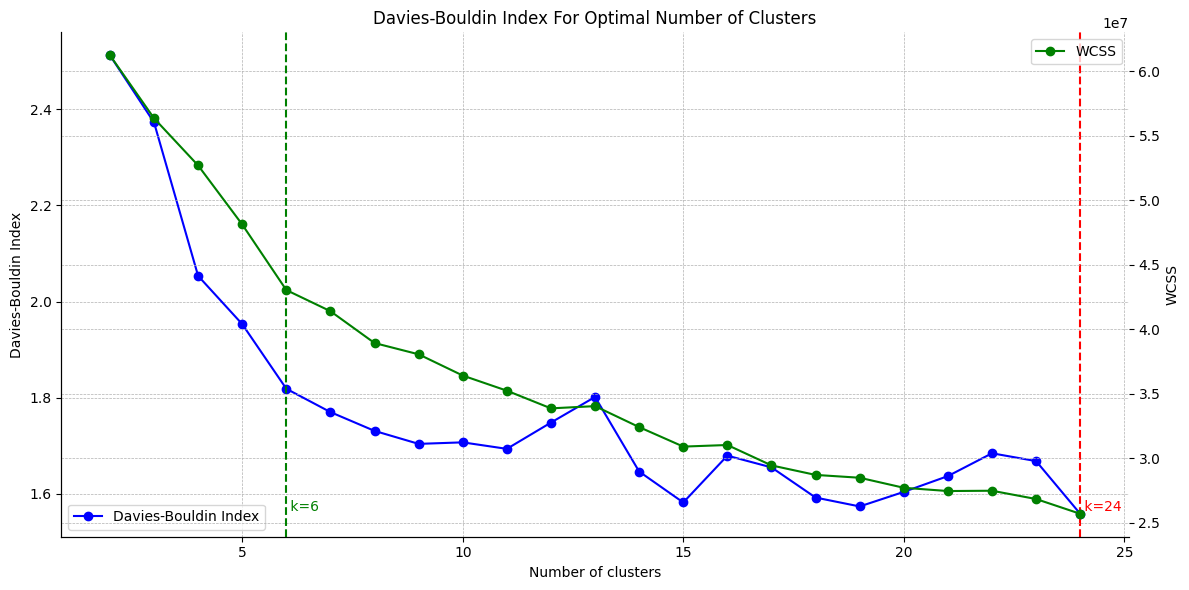

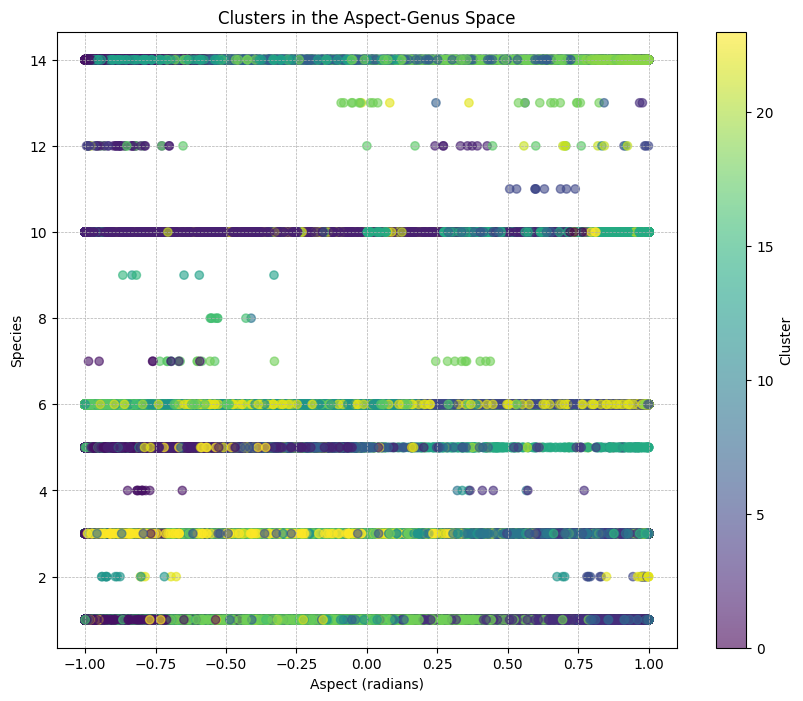

Clustering completed and cluster maps saved.


In [8]:
import os
from datetime import datetime
from utils import load_folder, calculate_slope_with_dates
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Remove warning
import warnings
warnings.filterwarnings("ignore")

def load_data_from_tile(path: str) -> tuple:
    """Load and preprocess data from a tile.

    Args:
        path (str): Path to the tile directory.

    Returns:
        tuple: Preprocessed features, weights, forest mask, species data, and shape of the original tile.
    """
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    f1 = amplitude_map_r
    f2 = np.cos(phase_map_r)
    f3 = np.sin(phase_map_r)
    f4 = offset_map_r
    f5 = amplitude_map_crswir
    f6 = offset_map_crswir
    f7 = elevation
    aspect_radians = np.radians(aspect)
    aspect_radians[np.isnan(aspect_radians)] = 0
    f8 = np.cos(aspect_radians)
    f9 = np.sin(aspect_radians)

    features = np.stack((f1.ravel(), f2.ravel(), f3.ravel(), f4.ravel(), f5.ravel(), f6.ravel(), f7.ravel(), f8.ravel(), f9.ravel()), axis=-1)
    filtered_features = features[forest_mask.ravel()]
    filtered_weights = weights[forest_mask.ravel()]

    # Load reference data
    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    # species = reference[0]
    # filtered_species = species[forest_mask]
    genus = reference[1]
    filtered_genus = genus[forest_mask]

    return filtered_features, filtered_weights, forest_mask, filtered_genus, f1.shape

# Initialize variables for stacking
all_features = []
all_weights = []
all_ref = []
tile_shapes = []

# Load data from all tiles
print('Loading data from all tiles')
for folder in tqdm(os.listdir(dir_)):
    path = os.path.join(dir_, folder)
    if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
        continue

    try:
        filtered_features, filtered_weights, forest_mask, filtered_ref, tile_shape = load_data_from_tile(path)
        all_features.append(filtered_features)
        all_weights.append(filtered_weights)
        all_ref.append(filtered_ref)
        tile_shapes.append((path, forest_mask, tile_shape))
    except Exception as e:
        print(f"Error processing {folder}: {e}")
        continue

# Stack all features, weights, and species
all_features_stacked = np.vstack(all_features)
all_weights_stacked = np.concatenate(all_weights)
all_ref_stacked = np.concatenate(all_ref)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features_stacked)

# Determine the optimal number of clusters using Davies-Bouldin index
davies_bouldin_indices = []
wcss = []  # Within-cluster sum of squares
K = range(2, 25)  # Range of number of clusters

print('Determining the optimal number of clusters using Davies-Bouldin index')
for k in tqdm(K):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    clusters = minibatch_kmeans.fit_predict(features_scaled, sample_weight=all_weights_stacked)
    wcss.append(minibatch_kmeans.inertia_)
    davies_bouldin_indices.append(davies_bouldin_score(features_scaled, clusters))

optimal_k = K[np.argmin(davies_bouldin_indices)]
optimal_k2 = K[np.argmax(np.diff(wcss, 2)) + 1]
print(f"The optimal number of clusters is (Davies-Bouldin): {optimal_k}")
print(f"The optimal number of clusters is (Elbow Method): {optimal_k2}")

# Plot Davies-Bouldin index and WCSS
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot the Davies-Bouldin Index
ax1.plot(K, davies_bouldin_indices, 'bo-', label='Davies-Bouldin Index')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Davies-Bouldin Index')
ax1.set_title('Davies-Bouldin Index For Optimal Number of Clusters')
ax1.legend()
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.axvline(x=optimal_k, color='r', linestyle='--')
ax1.text(optimal_k, min(davies_bouldin_indices), f' k={optimal_k}', color='r', verticalalignment='bottom')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
ax2.plot(K, wcss, 'go-', label='WCSS')
ax2.set_ylabel('WCSS')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.axvline(x=optimal_k2, color='g', linestyle='--')
ax2.text(optimal_k2, min(wcss), f' k={optimal_k2}', color='g', verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Apply MiniBatchKMeans with the optimal number of clusters
minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
clusters = minibatch_kmeans.fit_predict(features_scaled, sample_weight=all_weights_stacked)

# Reconstruct cluster maps for each tile
cluster_maps = []
index = 0
for path, forest_mask, tile_shape in tile_shapes:
    cluster_map = np.full(tile_shape, -1)
    n_points = forest_mask.ravel().sum()
    cluster_map.ravel()[forest_mask.ravel()] = clusters[index:index + n_points]
    index += n_points
    cluster_maps.append((path, cluster_map))

# Save or process cluster maps
# for path, cluster_map in cluster_maps:
#     output_path = os.path.join(path, 'cluster_map.tif')
#     with rasterio.open(output_path, 'w', driver='GTiff', height=cluster_map.shape[0], width=cluster_map.shape[1], count=1, dtype=cluster_map.dtype) as dst:
#         dst.write(cluster_map, 1)

# Plot the relationship between clusters, aspect, and species
aspect = all_features_stacked[:, 7]
valid_mask = (all_ref_stacked != 0)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(aspect[valid_mask], all_ref_stacked[valid_mask], c=clusters[valid_mask], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Aspect (radians)')
plt.ylabel('Species')
plt.title('Clusters in the Aspect-Genus Space')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Clustering completed and cluster maps saved.")


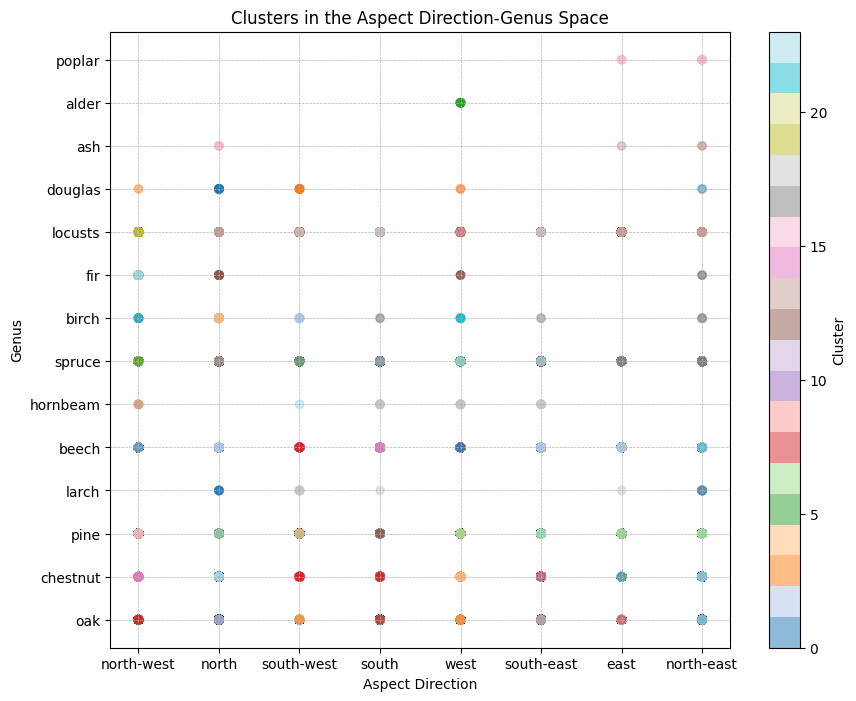

In [18]:
import matplotlib.pyplot as plt

# Define the genus mapping
genus_mapping = {
    1: 'oak', 2: 'fir', 3: 'pine', 4: 'douglas', 5: 'chestnut',
    6: 'spruce', 7: 'larch', 8: 'poplar', 9: 'ash', 10: 'beech',
    11: 'alder', 12: 'birch', 13: 'hornbeam', 14: 'locusts'
}

# Categorize aspect into directions
def categorize_aspect(aspect: np.ndarray) -> np.ndarray:
    """Categorize aspect into cardinal and intercardinal directions.

    Args:
        aspect (np.ndarray): Aspect values between -1 and 1.

    Returns:
        np.ndarray: Aspect categories ('north', 'north-east', 'east', 'south-east', 'south', 'south-west', 'west', 'north-west').
    """
    directions = np.empty(aspect.shape, dtype='<U10')
    directions[(aspect >= -1) & (aspect < -0.75)] = 'north'
    directions[(aspect >= -0.75) & (aspect < -0.5)] = 'north-east'
    directions[(aspect >= -0.5) & (aspect < -0.25)] = 'east'
    directions[(aspect >= -0.25) & (aspect < 0)] = 'south-east'
    directions[(aspect >= 0) & (aspect < 0.25)] = 'south'
    directions[(aspect >= 0.25) & (aspect < 0.5)] = 'south-west'
    directions[(aspect >= 0.5) & (aspect < 0.75)] = 'west'
    directions[(aspect >= 0.75) & (aspect <= 1)] = 'north-west'
    return directions


# Filter out null data
valid_mask = (all_ref_stacked != 0)

# Convert genus index to names
genus = np.vectorize(genus_mapping.get)(all_ref_stacked)

# Categorize aspect
aspect_directions = categorize_aspect(all_features_stacked[valid_mask, 7])

# Plot the relationship between clusters, aspect directions, and genus
plt.figure(figsize=(10, 8))
scatter = plt.scatter(aspect_directions, genus[valid_mask], c=clusters[valid_mask], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Aspect Direction')
plt.ylabel('Genus')
plt.title('Clusters in the Aspect Direction-Genus Space')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


## Davies bouldin with aspect and genus`

Loading data from all tiles


 70%|███████   | 56/80 [00:15<00:06,  3.85it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:21<00:00,  3.75it/s]


Determining the optimal number of clusters using Davies-Bouldin index


100%|██████████| 23/23 [01:33<00:00,  4.06s/it]


The optimal number of clusters is (Davies-Bouldin): 18
The optimal number of clusters is (Elbow Method): 3


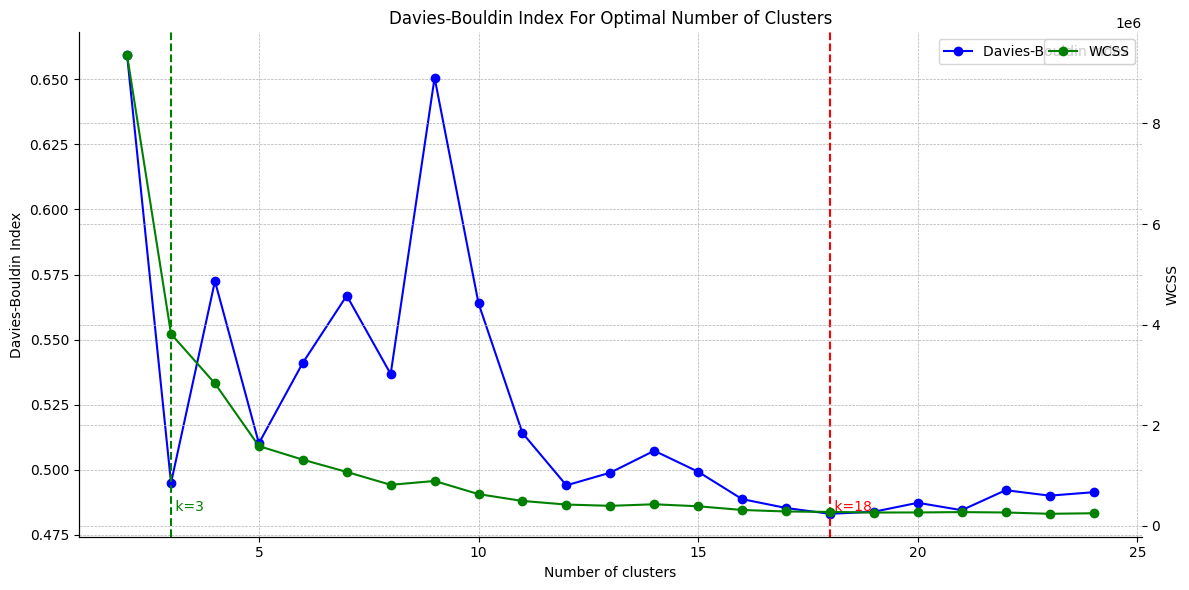

ValueError: 'c' argument has 7828414 elements, which is inconsistent with 'x' and 'y' with size 638001.

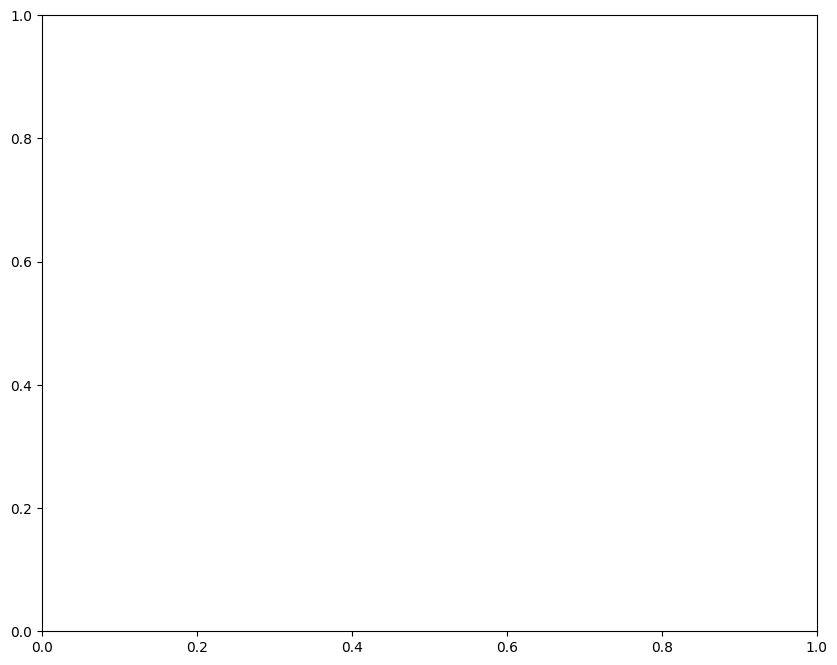

In [16]:
import os
from datetime import datetime
from utils import load_folder, calculate_slope_with_dates
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt

dir_ = '/Users/arthurcalvi/Data/species/validation/tiles'

# Remove warning
import warnings
warnings.filterwarnings("ignore")

def load_data_from_tile(path: str) -> tuple:
    """Load and preprocess data from a tile.

    Args:
        path (str): Path to the tile directory.

    Returns:
        tuple: Preprocessed features, weights, forest mask, species data, and shape of the original tile.
    """
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    f1 = amplitude_map_r
    f2 = np.cos(phase_map_r)
    f3 = np.sin(phase_map_r)
    f4 = offset_map_r
    f5 = amplitude_map_crswir
    f6 = offset_map_crswir
    f7 = elevation
    aspect_radians = np.radians(aspect)
    aspect_radians[np.isnan(aspect_radians)] = 0
    f8 = np.cos(aspect_radians)
    f9 = np.sin(aspect_radians)

    features = np.stack((f1.ravel(), f2.ravel(), f3.ravel(), f4.ravel(), f5.ravel(), f6.ravel(), f7.ravel(), f8.ravel(), f9.ravel()), axis=-1)
    filtered_features = features[forest_mask.ravel()]
    filtered_weights = weights[forest_mask.ravel()]

    # Load reference data
    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    filtered_genus = genus[forest_mask]

    return filtered_features, filtered_weights, forest_mask, filtered_genus, f1.shape

# Initialize variables for stacking
all_features = []
all_weights = []
all_ref = []
tile_shapes = []

# Load data from all tiles
print('Loading data from all tiles')
for folder in tqdm(os.listdir(dir_)):
    path = os.path.join(dir_, folder)
    if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
        continue

    try:
        filtered_features, filtered_weights, forest_mask, filtered_ref, tile_shape = load_data_from_tile(path)
        all_features.append(filtered_features)
        all_weights.append(filtered_weights)
        all_ref.append(filtered_ref)
        tile_shapes.append((path, forest_mask, tile_shape))
    except Exception as e:
        print(f"Error processing {folder}: {e}")
        continue

# Stack all features, weights, and species
all_features_stacked = np.vstack(all_features)
all_weights_stacked = np.concatenate(all_weights)
all_ref_stacked = np.concatenate(all_ref)

# Extract aspect and genus for clustering
aspect = all_features_stacked[:, 7]  # Aspect
genus = all_ref_stacked  # Genus
valid_mask = (genus != 0)  # Mask to filter out invalid data

# Prepare data for clustering
aspect_genus_data = np.stack((aspect, genus), axis=-1)

# Scale features
scaler = StandardScaler()
aspect_genus_scaled = scaler.fit_transform(aspect_genus_data)

# Determine the optimal number of clusters using Davies-Bouldin index
davies_bouldin_indices = []
wcss = []  # Within-cluster sum of squares
K = range(2, 25)  # Range of number of clusters

print('Determining the optimal number of clusters using Davies-Bouldin index')
for k in tqdm(K):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    clusters = minibatch_kmeans.fit_predict(aspect_genus_scaled, sample_weight=all_weights_stacked)
    wcss.append(minibatch_kmeans.inertia_)
    davies_bouldin_indices.append(davies_bouldin_score(aspect_genus_scaled, clusters))

optimal_k = K[np.argmin(davies_bouldin_indices)]
optimal_k2 = K[np.argmax(np.diff(wcss, 2)) + 1]
print(f"The optimal number of clusters is (Davies-Bouldin): {optimal_k}")
print(f"The optimal number of clusters is (Elbow Method): {optimal_k2}")

# Plot Davies-Bouldin index and WCSS
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot the Davies-Bouldin Index
ax1.plot(K, davies_bouldin_indices, 'bo-', label='Davies-Bouldin Index')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Davies-Bouldin Index')
ax1.set_title('Davies-Bouldin Index For Optimal Number of Clusters')
ax1.legend()
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.axvline(x=optimal_k, color='r', linestyle='--')
ax1.text(optimal_k, min(davies_bouldin_indices), f' k={optimal_k}', color='r', verticalalignment='bottom')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
ax2.plot(K, wcss, 'go-', label='WCSS')
ax2.set_ylabel('WCSS')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.axvline(x=optimal_k2, color='g', linestyle='--')
ax2.text(optimal_k2, min(wcss), f' k={optimal_k2}', color='g', verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Apply MiniBatchKMeans with the optimal number of clusters
minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
clusters = minibatch_kmeans.fit_predict(aspect_genus_scaled, sample_weight=all_weights_stacked)

# Reconstruct cluster maps for each tile
cluster_maps = []
index = 0
for path, forest_mask, tile_shape in tile_shapes:
    cluster_map = np.full(tile_shape, -1)
    n_points = forest_mask.ravel().sum()
    cluster_map[forest_mask] = clusters[index:index + n_points]
    index += n_points
    cluster_maps.append((path, cluster_map))

# Save or process cluster maps
# for path, cluster_map in cluster_maps:
#     output_path = os.path.join(path, 'cluster_map.tif')
#     with rasterio.open(output_path, 'w', driver='GTiff', height=cluster_map.shape[0], width=cluster_map.shape[1], count=1, dtype=cluster_map.dtype) as dst:
#         dst.write(cluster_map, 1)

# Plot the relationship between clusters, aspect, and species
plt.figure(figsize=(10, 8))
scatter = plt.scatter(aspect[valid_mask], genus[valid_mask], c=clusters[valid_mask], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Aspect (radians)')
plt.ylabel('Species')
plt.title('Clusters in the Aspect-Genus Space')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Clustering completed and cluster maps saved.")


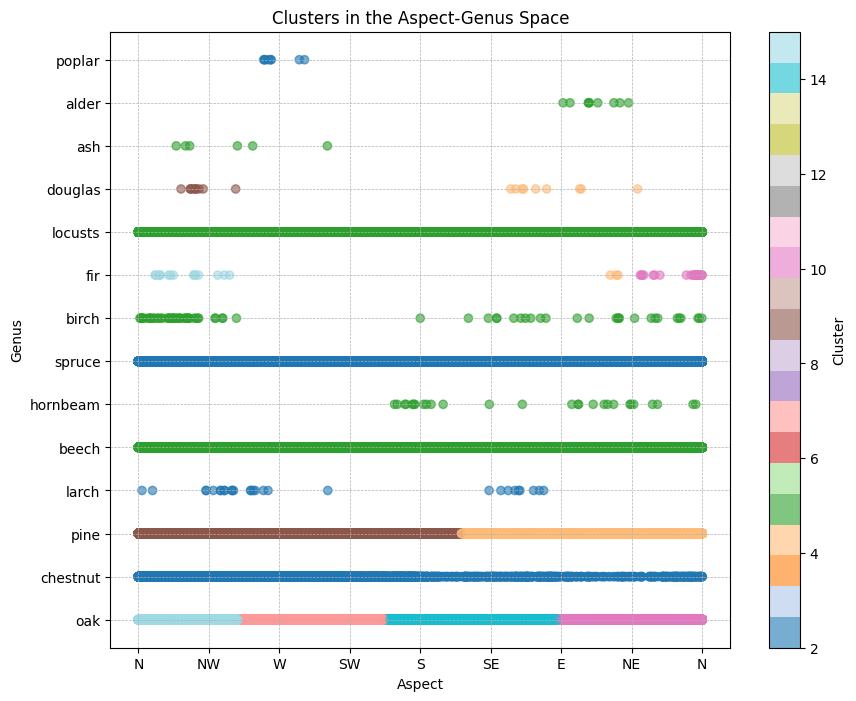

Clustering completed and cluster maps saved.


In [21]:
# Define the genus mapping
genus_mapping = {
    1: 'oak', 2: 'fir', 3: 'pine', 4: 'douglas', 5: 'chestnut',
    6: 'spruce', 7: 'larch', 8: 'poplar', 9: 'ash', 10: 'beech',
    11: 'alder', 12: 'birch', 13: 'hornbeam', 14: 'locusts'
}

# Define aspect direction labels for tick marks
direction_labels = {
    -1: 'N', -0.75: 'NW', -0.5: 'W', -0.25: 'SW', 
    0: 'S', 0.25: 'SE', 0.5: 'E', 0.75: 'NE', 1: 'N'
}

# Plot the relationship between clusters, aspect, and genus
plt.figure(figsize=(10, 8))
scatter = plt.scatter(aspect[valid_mask], [genus_mapping.get(g, 'Unknown') for g in genus[valid_mask]], c=clusters[valid_mask], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Aspect')
plt.ylabel('Genus')

# Set custom tick labels for aspect
plt.xticks(ticks=list(direction_labels.keys()), labels=list(direction_labels.values()))

plt.title('Clusters in the Aspect-Genus Space')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Clustering completed and cluster maps saved.")
